In [1]:
from pandas import read_csv, DataFrame
import pandas as pd
import numpy as np


#get file from data pre processing notebook. This file has all the column we need to start the data profiling phase

filepath=r'dataset/df_msg_encoded.csv'

file_tag = 'df_msg_encoded'

data = pd.read_csv(filepath, na_values="")

/var/folders/cb/3dkrbpbn63zcqbvg5csx6rhc0000gp/T/ipykernel_15555/3908158163.py:12: DtypeWarning: Columns (0,2,13,24) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath, na_values="")


# DSLabs functions

In [3]:
%run "dslabs_functions.py"

dslabs_functions loaded


In [4]:
from pandas import read_csv, DataFrame
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_bar_chart

dslabs_functions loaded


# MV Analysis

Variables with their respective percentages of missing values:
days_diff_complained_at_sent_at: 99.96%
days_diff_purchased_at_sent_at: 99.93%
days_diff_clicked_first_time_at_sent_at: 98.25%
days_diff_unsubscribed_at_sent_at: 96.36%
platform: 93.19%
days_diff_opened_first_time_at_sent_at: 85.20%
days_diff_first_purchase_date_sent_at: 80.34%
email_provider: 51.26%
total_count: 14.42%
days_diff_started_at_sent_at: 14.42%
subject_length: 11.33%
subject_with_personalization: 11.33%
subject_with_deadline: 11.33%
subject_with_emoji: 11.33%
subject_with_bonuses: 11.33%
subject_with_discount: 11.33%
subject_with_saleout: 11.33%
topic: 0.87%


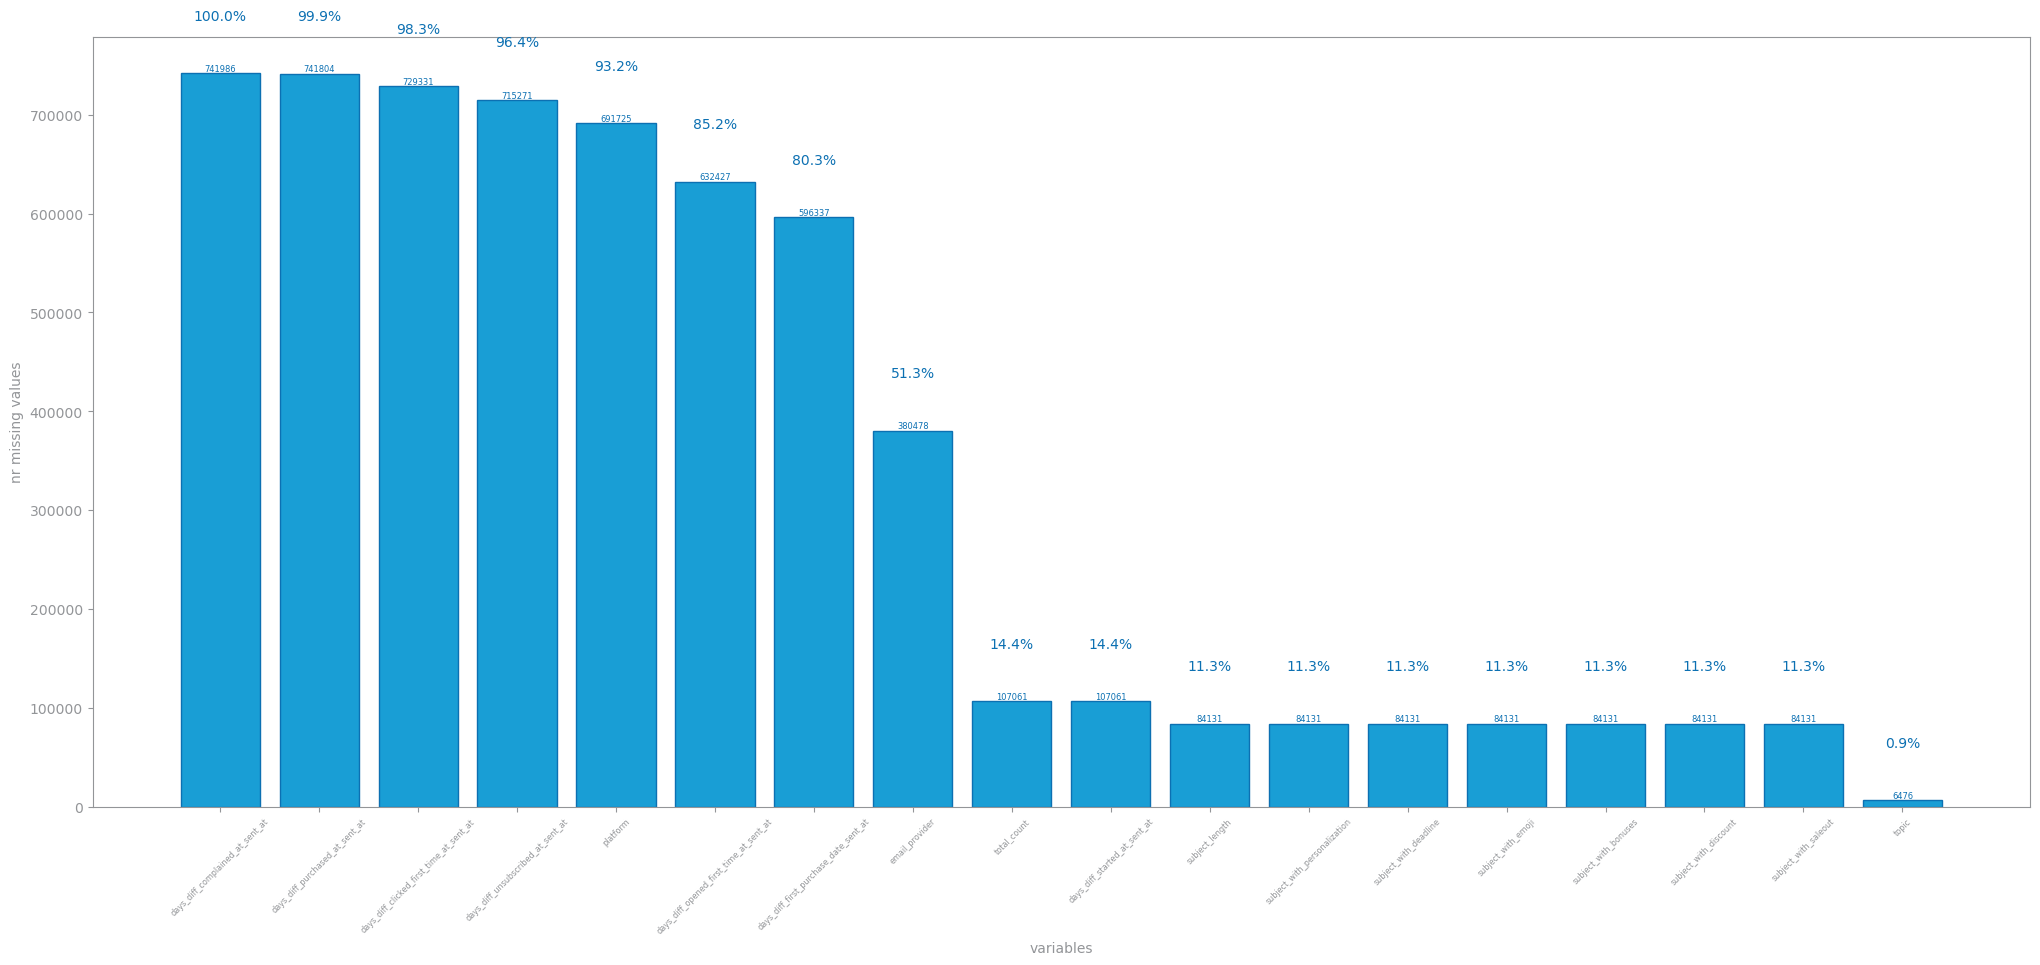

In [5]:
mv: dict[str, int] = {}
total_rows = len(data)

# Calculate the number of missing values and percentage for each variable
for var in data.columns:
    nr: int = data[var].isna().sum()
    if nr > 0:
        percentage = (nr / total_rows) * 100
        mv[var] = (nr, percentage)

# Sort the dictionary by the number of missing values in descending order
sorted_mv = dict(sorted(mv.items(), key=lambda item: item[1][0], reverse=True))

variables = list(sorted_mv.keys())
missing_values = [val[0] for val in sorted_mv.values()]
percentages = [val[1] for val in sorted_mv.values()]

# Print the list of variables with their respective percentages of missing values
print("Variables with their respective percentages of missing values:")
for var, perc in zip(variables, percentages):
    print(f"{var}: {perc:.2f}%")

# Plotting the bar chart
figure(figsize=(25, 10))  # (width, height)

plot_bar_chart(
    variables,
    missing_values,
    xlabel="variables",
    ylabel="nr missing values",
)

# Annotate the bars with percentages
for i, (var, perc) in enumerate(zip(variables, percentages)):
    text(i, missing_values[i] + max(missing_values) * 0.08, f"{perc:.1f}%", ha="center", va="center_baseline")

# Display the chart
show()


# Strategies

## Dropping Missing Values

OR (any)
- any establishes that a record is deleted if any of its variable values is missing, 
- or it requires them all to be missing (all).

In [ ]:
data_drop_na_any: DataFrame = data.dropna(how="any", inplace=False)
data_drop_na_any.shape

OR (all)

In [ ]:
data_drop_na_all: DataFrame = data.dropna(how="all", inplace=False)
data_drop_na_all.shape

OR dropping columns

In [ ]:
data_drop_na_columns: DataFrame = data.dropna(axis=1, how="any", inplace=False)
data_drop_na_columns.shape

## Filling missing values


- constant: the constant value chosen depends on the type of variable (usually: NaN, -1 or 0 for numeric, 'NA' for symbolic and False for boolean);
- mean, median and most_frequent: the first two only applicable for numeric variables, and the last one mostly interesting for symbolic variables;

In [ ]:
from numpy import ndarray
from pandas import concat, DataFrame
from sklearn.impute import SimpleImputer, KNNImputer
from dslabs_functions import get_variable_types, mvi_by_filling


def mvi_by_filling(data: DataFrame, strategy: str = "frequent") -> DataFrame:
    # Removed the df variable and replaced it with data directly
    variables: dict = get_variable_types(data)
    stg_num, v_num = "mean", -1
    stg_sym, v_sym = "most_frequent", "NA"
    stg_bool, v_bool = "most_frequent", False

    if strategy != "knn":
        lst_dfs: list = []
        if strategy == "constant":
            stg_num, stg_sym, stg_bool = "constant", "constant", "constant"
        
        # Impute numeric variables
        if len(variables["numeric"]) > 0:
            imp = SimpleImputer(strategy=stg_num, fill_value=v_num, copy=True)
            tmp_nr = DataFrame(
                imp.fit_transform(data[variables["numeric"]]),
                columns=variables["numeric"],
            )
            lst_dfs.append(tmp_nr)
        
        # Impute symbolic variables
        if len(variables["symbolic"]) > 0:
            imp = SimpleImputer(strategy=stg_sym, fill_value=v_sym, copy=True)
            tmp_sb = DataFrame(
                imp.fit_transform(data[variables["symbolic"]]),
                columns=variables["symbolic"],
            )
            lst_dfs.append(tmp_sb)
        
        # Impute binary variables
        if len(variables["binary"]) > 0:
            imp = SimpleImputer(strategy=stg_bool, fill_value=v_bool, copy=True)
            tmp_bool = DataFrame(
                imp.fit_transform(data[variables["binary"]]),
                columns=variables["binary"],
            )
            lst_dfs.append(tmp_bool)

        # Concatenate all filled data frames
        data = concat(lst_dfs, axis=1)  # Replacing df with data
    else:
        imp = KNNImputer(n_neighbors=5)
        imp.fit(data)
        ar: ndarray = imp.transform(data)
        data = DataFrame(ar, columns=data.columns, index=data.index)  # Replacing df with data

    return data  # Returning data

# Usage
data: DataFrame = mvi_by_filling(data, strategy="frequent")
print(data.head(10))
